### Load accident data corresponding to far_part 121

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random

import collections
import matplotlib.pyplot as plt
%matplotlib inline

## New - With the implementation of eADMS in 2006, the "Events_Sequence" table will replace the "Occurrences"
## table and the "Findings" table will replace the "Seq_of_events" table.

Events_Sequence = pd.read_csv('Events_Sequence.txt', sep = '\t')  ## eADMS coding for accidents after 2006
aircraft = pd.read_excel('aircraft.xlsx')
occurrences = pd.read_csv('Occurrences.txt', sep = ',')
seq_of_events_ = pd.read_csv('seq_of_events.txt', sep = '\t') ## pre eADMS coding for accidents before 2006

narratives = pd.read_excel('narratives.xlsx')
metaData = pd.read_excel('metaData.xlsx')
events = pd.read_excel('events.xlsx')
engines = pd.read_excel('engines.xlsx')
injury = pd.read_excel('injury.xlsx')
findings = pd.read_excel('findings.xlsx')

In [2]:
random.seed(123)

In [3]:
events[events['ev_id']=='20001208X06203']

,ev_id,ntsb_no,ev_type,ev_date,ev_dow,ev_time,ev_tmzn,ev_city,ev_state,ev_country,...,invest_agy,ntsb_docket,ntsb_notf_from,ntsb_notf_date,ntsb_notf_tm,fiche_number,lchg_date,lchg_userid,wx_cond_basic,faa_dist_office
985,20001208X06203,DCA96MA068,ACC,1996-07-06,Sa,1424.0,CDT,PENSACOLA,FL,USA,...,N,1696.0,NaN,1996-07-06,0.0,IMAGE,2019-06-06 16:04:47.680,broda,VMC,NaN


In [4]:
Events_Sequence[Events_Sequence['ev_id'] == '20001208X08803']

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Occurrence_Description,phase_no,eventsoe_no,Defining_ev,lchg_date,lchg_userid
0,20001208X08803,1,3,400240,Enroute - Loss of control in flight,400,240,1,5/13/2019 14:50:49,bowl


In [5]:
print ('The values of cause_factor are', set(seq_of_events_['Cause_Factor'].values))

The values of cause_factor are {nan, 'F', '1', 'X', 'D', 'c', '2', 'f', ' ', 'C'}


#### Process the values of cause_factor

In [6]:
seq_of_events_[seq_of_events_['Cause_Factor'] == 'X']

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
58266,20001213X34629,1,2,1,2,24500,X,3131,4000.0,12/13/2000 16:58:22,dbo
76321,20001213X31660,1,1,2,2,24539,X,3131,4000.0,12/13/2000 14:40:01,dbo
103128,20001214X37504,1,4,1,1,20200,X,2511,0.0,12/14/2000 13:05:05,dbo
168019,20001213X33849,1,2,1,2,24551,X,3113,4000.0,12/13/2000 16:13:55,dbo
197452,20001214X39233,1,2,3,1,20000,X,2207,0.0,12/14/2000 14:24:49,dbo
239753,20001211X15049,1,1,2,2,24551,X,3113,4000.0,12/11/2000 15:07:06,dbo


In [7]:
seq_of_events = seq_of_events_.dropna(axis = 0, subset =['Cause_Factor']).copy()

In [8]:
seq_of_events.loc[seq_of_events.Cause_Factor == '1','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == '2','Cause_Factor'] = 'F'
seq_of_events.loc[seq_of_events.Cause_Factor == 'c','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == 'f','Cause_Factor'] = 'F'
seq_of_events.loc[seq_of_events.Cause_Factor == 'D','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == 'X','Cause_Factor'] = 'F'

indexes = seq_of_events[seq_of_events['Cause_Factor'] == ' '].index
seq_of_events.drop(indexes, inplace = True)

In [9]:
set(seq_of_events['Cause_Factor'].values)

{'C', 'F'}

In [10]:
metaData['code_iaids'] = metaData['code_iaids'].astype(str)
indices = seq_of_events[seq_of_events['Subj_Code'] == 0].index
seq_of_events.drop(indices, inplace = True)

In [11]:
indices

Int64Index([133286, 163656, 163657, 246474], dtype='int64')

### Accident Statistical Summary

#### Total number of accidents in far_part 121

In [12]:
ev_ID = aircraft['ev_id'].values.tolist()

## Remove duplicated event IDs
ev_ID = list(set(ev_ID))

print ('There are {} accidents in NTSB database with far_part equal to 121'.format(len(ev_ID)))
print ('The data ranges from {} to {}'.format(min(events['ev_year'].values), max(events['ev_year'].values)))

There are 2243 accidents in NTSB database with far_part equal to 121
The data ranges from 1982 to 2019


#### Basic statistics

In [13]:
events_part = events[events['ev_id'].isin(ev_ID)]

In [14]:
events_part['ev_highest_injury'].fillna('Not Reported', inplace = True)

In [15]:
from itertools import product
combs = pd.DataFrame(list(product(set(events_part['ev_year'].values), set(events_part['ev_highest_injury'].values))), 
                     columns=['ev_year', 'ev_highest_injury'])

In [16]:
g = events_part.groupby(['ev_year','ev_highest_injury']).size().to_frame('count').reset_index()
g

,ev_year,ev_highest_injury,count
0,1982,FATL,5
1,1982,MINR,5
2,1982,NONE,27
3,1982,SERS,8
4,1983,FATL,4
5,1983,MINR,6
6,1983,NONE,58
7,1983,SERS,11
8,1984,FATL,1
9,1984,MINR,4


In [17]:
result = g.merge(combs, how = 'right').fillna(0)

In [18]:
FATL_res = result[result['ev_highest_injury'] == 'FATL'].sort_values(by=['ev_year'])
MINR_res = result[result['ev_highest_injury'] == 'MINR'].sort_values(by=['ev_year'])
NONE_res = result[result['ev_highest_injury'] == 'NONE'].sort_values(by=['ev_year'])
SERS_res = result[result['ev_highest_injury'] == 'SERS'].sort_values(by=['ev_year'])
UNKN_res = result[result['ev_highest_injury'] == 'UNKN'].sort_values(by=['ev_year'])
No_Report_res = result[result['ev_highest_injury'] == 'Not Reported'].sort_values(by=['ev_year'])

In [19]:
aircraft['damage'].fillna('Not Reported', inplace = True)

In [20]:
aircraft['ev_year'] = aircraft['ev_id'].astype(str).str[:4]

from itertools import product
aicrftCombs = pd.DataFrame(list(product(set(aircraft['ev_year'].values), set(aircraft['damage'].values))), 
                     columns=['ev_year', 'damage'])

aircraftDamage = aircraft['damage'].groupby([aircraft['ev_year'], aircraft['damage']]).size().to_frame('count').reset_index()

aircraftResult = aircraftDamage.merge(aicrftCombs, how = 'right').fillna(0)

In [21]:
aircraftResult[aircraftResult['ev_year'] == '2015']

,ev_year,damage,count
58,2015,MINR,6.0
59,2015,NONE,21.0
60,2015,Not Reported,1.0
61,2015,SUBS,7.0
89,2015,UNK,0.0
90,2015,DEST,0.0


In [22]:
aircraftResult.loc[aircraftResult['ev_year'] == '2000']

,ev_year,damage,count
0,2000,DEST,60.0
1,2000,MINR,472.0
2,2000,NONE,532.0
3,2000,SUBS,246.0
4,2000,UNK,1.0
93,2000,Not Reported,0.0


In [23]:
aircraftResult

,ev_year,damage,count
0,2000,DEST,60.0
1,2000,MINR,472.0
2,2000,NONE,532.0
3,2000,SUBS,246.0
4,2000,UNK,1.0
5,2001,DEST,1.0
6,2001,MINR,25.0
7,2001,NONE,34.0
8,2001,SUBS,24.0
9,2002,DEST,8.0


In [24]:
idx = aircraftResult.index[aircraftResult['ev_year'] == '2000']

aircraftResult.drop(list(idx), inplace = True)

###### Aircraft damage VS year

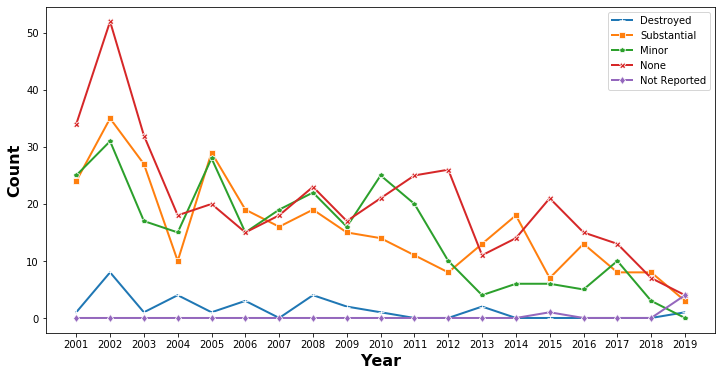

In [25]:
aircraft_DEST_res = aircraftResult[aircraftResult['damage'] == 'DEST'].sort_values(by=['ev_year'])
aircraft_SERS_res = aircraftResult[aircraftResult['damage'] == 'SUBS'].sort_values(by=['ev_year'])
aircraft_MINR_res = aircraftResult[aircraftResult['damage'] == 'MINR'].sort_values(by=['ev_year'])
aircraft_NONE_res = aircraftResult[aircraftResult['damage'] == 'NONE'].sort_values(by=['ev_year'])
aircraft_UNKN_res = aircraftResult[aircraftResult['damage'] == 'Not Reported'].sort_values(by=['ev_year'])

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(aircraft_DEST_res['ev_year'].values, aircraft_DEST_res['count'].values, marker = '+', lw = 2)
sns.lineplot(aircraft_SERS_res['ev_year'].values, aircraft_SERS_res['count'].values, marker = 's', lw = 2)
sns.lineplot(aircraft_MINR_res['ev_year'].values, aircraft_MINR_res['count'].values, marker = 'p', lw = 2)
sns.lineplot(aircraft_NONE_res['ev_year'].values, aircraft_NONE_res['count'].values, marker = 'X', lw = 2)
sns.lineplot(aircraft_UNKN_res['ev_year'].values, aircraft_UNKN_res['count'].values, marker = 'd', lw = 2)
plt.legend(['Destroyed', 'Substantial', 'Minor', 'None', 'Not Reported'])
plt.xlabel('Year', fontsize = 16, fontweight = 'bold')
plt.ylabel('Count', fontsize = 16, fontweight = 'bold')
plt.savefig('damage_vs_year.pdf')

##### Injury VS year

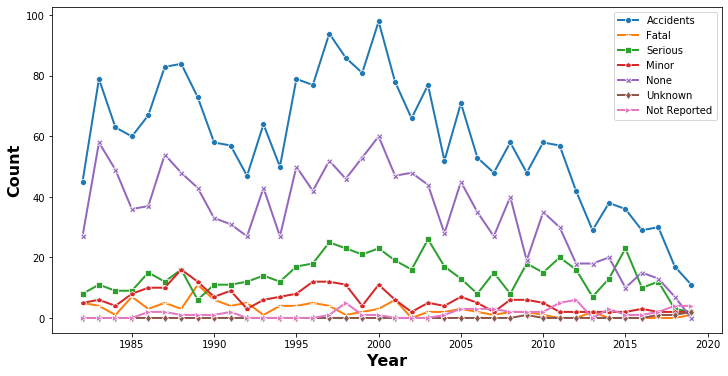

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

noEventsbyYear = events_part['ev_year'].groupby(events_part['ev_year'].rename('year')).agg({'count'})
sns.lineplot(No_Report_res['ev_year'].values, noEventsbyYear['count'], marker = 'o', lw = 2)

sns.lineplot(FATL_res['ev_year'].values, FATL_res['count'].values, marker = '+', lw = 2)
sns.lineplot(SERS_res['ev_year'].values, SERS_res['count'].values, marker = 's', lw = 2)
sns.lineplot(MINR_res['ev_year'].values, MINR_res['count'].values, marker = 'p', lw = 2)
sns.lineplot(NONE_res['ev_year'].values, NONE_res['count'].values, marker = 'X', lw = 2)
sns.lineplot(UNKN_res['ev_year'].values, UNKN_res['count'].values, marker = 'd', lw = 2)
sns.lineplot(No_Report_res['ev_year'].values, No_Report_res['count'].values, marker = '>', lw = 2)

plt.xlabel('Year', fontsize = 16, fontweight = 'bold')
plt.ylabel('Count', fontsize = 16, fontweight = 'bold')
plt.legend(['Accidents', 'Fatal', 'Serious', 'Minor', 'None', 'Unknown', 'Not Reported'])
plt.savefig('injury_vs_year.pdf')

#### Accident vs Aircraft Manufactuer

In [27]:
acft_make_counter = collections.Counter(aircraft['acft_make'].str.title())
acft_make_counter_plot = {k: v for k, v in acft_make_counter.items() if v > 5}

Text(0, 0.5, 'No of accidents')

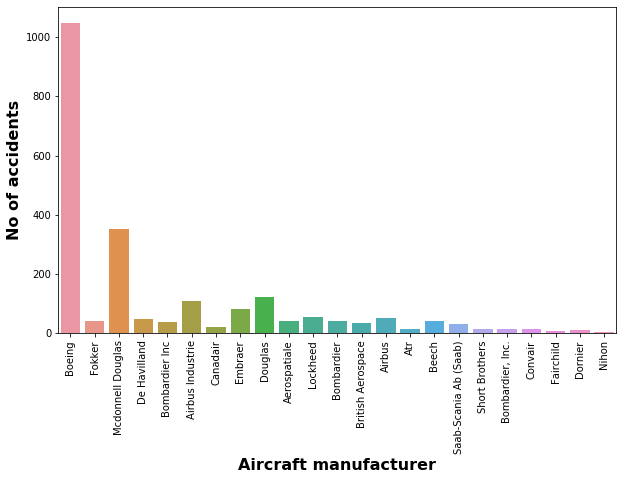

In [28]:
plt.figure(figsize = (10, 6))
sns.barplot(list(acft_make_counter_plot.keys()), list(acft_make_counter_plot.values()))
plt.xticks(rotation=90)
plt.xlabel('Aircraft manufacturer', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of accidents', fontsize = 16, fontweight = 'bold')

#### Accident vs Event Type

In [29]:
ev_type_counter = collections.Counter(events['ev_type'].fillna('Unknown'))
ev_type_keys = ['Accident','Incident','Unknown']

Text(0, 0.5, 'No of events')

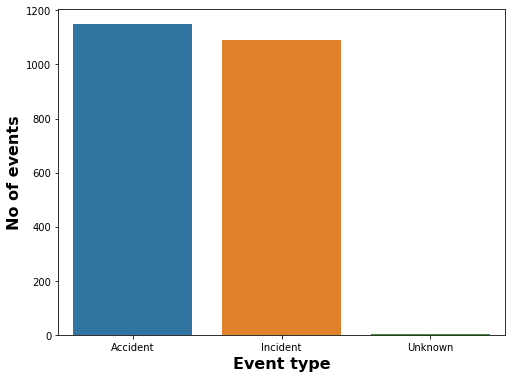

In [30]:
plt.figure(figsize = (8, 6))
sns.barplot(ev_type_keys, list(ev_type_counter.values()))
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Year

Text(0, 0.5, 'No of events')

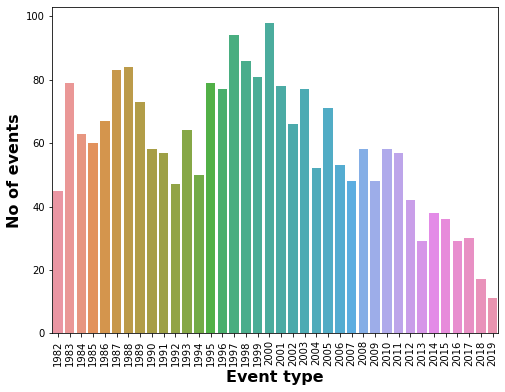

In [31]:
ev_year_counter = collections.Counter(events['ev_year'])

plt.figure(figsize = (8, 6))
sns.barplot(list(ev_year_counter.keys()), list(ev_year_counter.values()))
plt.xticks(rotation=90)
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs State

Text(0, 0.5, 'No of events')

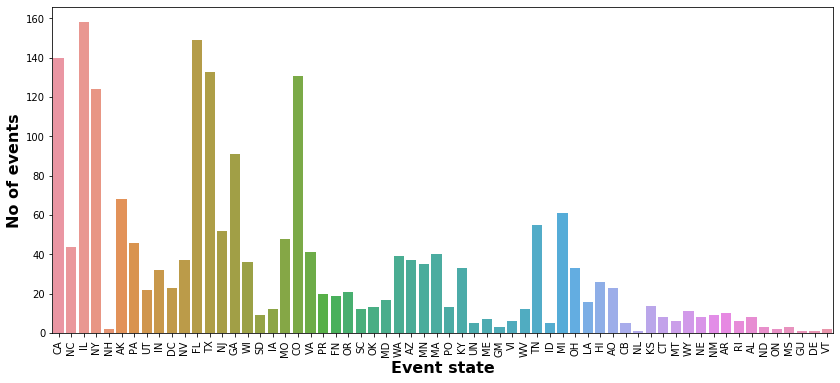

In [32]:
ev_state_counter = collections.Counter(events['ev_state'])

plt.figure(figsize = (14, 6))
sns.barplot(list(ev_state_counter.keys()), list(ev_state_counter.values()))
plt.xticks(rotation=90)
plt.xlabel('Event state', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Wind Gusting

In [33]:
gust_ind_counter = collections.Counter(events['gust_ind'].fillna('Not Reported'))
gust_ind_keys = ['Not Gusting', 'Gusting', 'Unknown', 'Not Reported']

Text(0, 0.5, 'No of events')

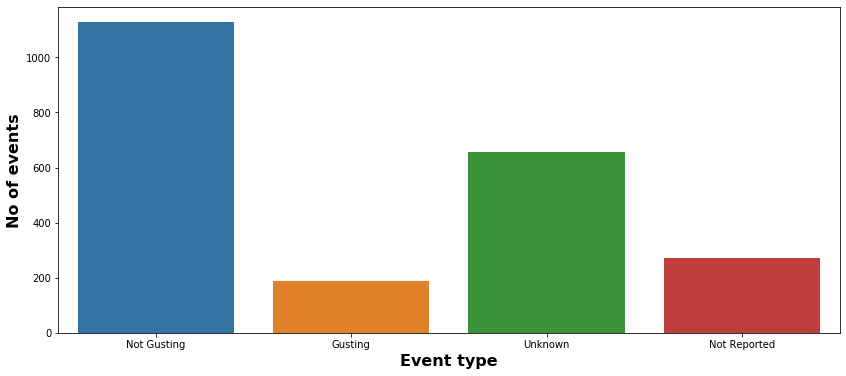

In [34]:
plt.figure(figsize = (14, 6))
sns.barplot(gust_ind_keys, list(gust_ind_counter.values()))
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Airport Elevation

In [35]:
elevation = events['apt_elev'].values
elevation = elevation[~np.isnan(elevation)]

Text(0, 0.5, 'Probability')

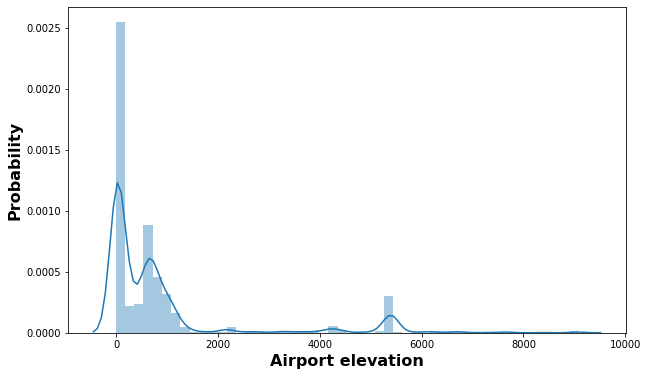

In [36]:
plt.figure(figsize = (10, 6))
sns.distplot(elevation)
plt.xlabel('Airport elevation', fontsize = 16, fontweight = 'bold')
plt.ylabel('Probability', fontsize = 16, fontweight = 'bold')

#### Accident vs Highest Injury

Text(0, 0.5, 'No of events')

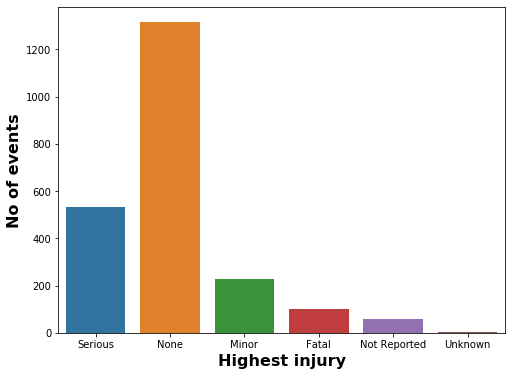

In [37]:
ev_highest_injury_counter = collections.Counter(events['ev_highest_injury'].fillna('Not Reported'))
ev_highest_injury_keys = ['Serious', 'None', 'Minor', 'Fatal', 'Not Reported', 'Unknown']

plt.figure(figsize = (8, 6))
sns.barplot(ev_highest_injury_keys, list(ev_highest_injury_counter.values()))
plt.xlabel('Highest injury', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Aircraft Damage

In [38]:
ev_aircraft_damage_counter = collections.Counter(aircraft['damage'].fillna('Not Reported'))
ev_aircraft_damage_counter

Counter({'NONE': 918,
         'SUBS': 543,
         'MINR': 749,
         'DEST': 88,
         'Not Reported': 5,
         'UNK': 5})

#### Accident vs Location

Text(0, 0.5, 'No of events')

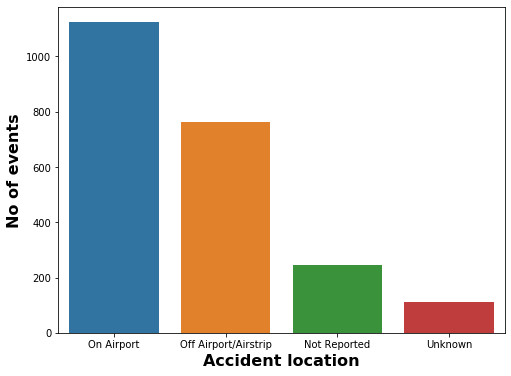

In [39]:
ev_nr_apt_loc_counter = collections.Counter(events['ev_nr_apt_loc'].fillna('Not Reported'))
ev_nr_apt_loc_keys = ['On Airport', 'Off Airport/Airstrip', 'Not Reported', 'Unknown']

plt.figure(figsize = (8, 6))
sns.barplot(ev_nr_apt_loc_keys, list(ev_nr_apt_loc_counter.values()))
plt.xlabel('Accident location', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Light Condition

In [40]:
light_cond_counter = collections.Counter(events['light_cond'].fillna('Unknown'))

light_cond_keys = ['Day','Night/Dark','Night', 'Not Reported', 'Condition-Unknown', 'Dusk', 'Dawn', 'Night//Bright']

Text(0, 0.5, 'No of events')

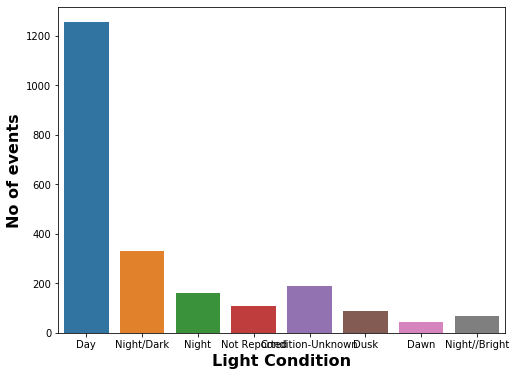

In [41]:
plt.figure(figsize = (8, 6))
sns.barplot(light_cond_keys, list(light_cond_counter.values()))
plt.xlabel('Light Condition', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Engine Type

In [42]:
eng_type_counter = collections.Counter(engines['eng_type'].fillna('Not Reported'))
eng_type_keys = ['Turbo Fan', 'Turbo Prop', 'Unknown', 'Turbo Jet', 'Reciprocating', 'Not Reported', 'Turbo Shaft']

Text(0, 0.5, 'No of events')

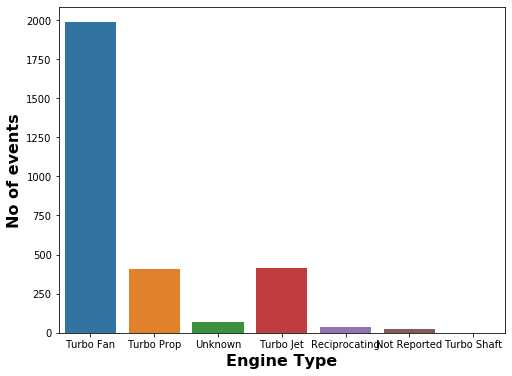

In [43]:
plt.figure(figsize = (8, 6))
sns.barplot(eng_type_keys, list(eng_type_counter.values()))
plt.xlabel('Engine Type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Airframe Hours

Text(0, 0.5, 'Probability')

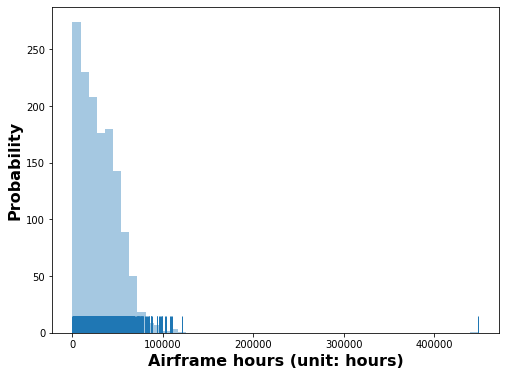

In [44]:
afm_hrs = aircraft['afm_hrs'].values
afm_hrs = afm_hrs[~np.isnan(afm_hrs)]

plt.figure(figsize = (8, 6))
sns.distplot(afm_hrs, kde=False, rug=True)
plt.xlabel('Airframe hours (unit: hours)', fontsize = 16, fontweight = 'bold')
plt.ylabel('Probability', fontsize = 16, fontweight = 'bold')

#### Aircraft Basic Characteristics

In [45]:
aircraft['num_eng']

0       2.0
1       2.0
2       3.0
3       2.0
4       4.0
5       2.0
6       3.0
7       2.0
8       2.0
9       2.0
10      2.0
11      2.0
12      NaN
13      3.0
14      NaN
15      4.0
16      2.0
17      2.0
18      2.0
19      2.0
20      3.0
21      NaN
22      3.0
23      2.0
24      2.0
25      NaN
26      2.0
27      2.0
28      4.0
29      2.0
       ... 
2278    0.0
2279    2.0
2280    2.0
2281    2.0
2282    4.0
2283    3.0
2284    2.0
2285    NaN
2286    2.0
2287    2.0
2288    2.0
2289    2.0
2290    2.0
2291    2.0
2292    2.0
2293    2.0
2294    3.0
2295    2.0
2296    2.0
2297    2.0
2298    2.0
2299    4.0
2300    2.0
2301    2.0
2302    2.0
2303    2.0
2304    NaN
2305    2.0
2306    2.0
2307    2.0
Name: num_eng, Length: 2308, dtype: float64

In [46]:
aircraft['oper_pax_cargo']

0        PAX
1       CARG
2       PACA
3       PACA
4       PACA
5        PAX
6        PAX
7       PACA
8        PAX
9        PAX
10       PAX
11       PAX
12      CARG
13       PAX
14       PAX
15      PACA
16       PAX
17      PACA
18      CARG
19      PACA
20      PACA
21      CARG
22      CARG
23      PACA
24       PAX
25       PAX
26       PAX
27       PAX
28       PAX
29       PAX
        ... 
2278    CARG
2279     PAX
2280     PAX
2281     PAX
2282    CARG
2283    PACA
2284     PAX
2285     NaN
2286    CARG
2287     PAX
2288     PAX
2289     PAX
2290     PAX
2291     PAX
2292     PAX
2293     PAX
2294     PAX
2295     PAX
2296     PAX
2297     PAX
2298     PAX
2299    CARG
2300     PAX
2301     PAX
2302     PAX
2303     PAX
2304     PAX
2305     PAX
2306     PAX
2307     PAX
Name: oper_pax_cargo, Length: 2308, dtype: object

In [47]:
events['light_cond']

0       DAYL
1       DAYL
2       DAYL
3       DAYL
4       DAYL
5       DAYL
6       NDRK
7       NDRK
8       NITE
9       DAYL
10      DAYL
11        NR
12      DAYL
13       NaN
14      DAYL
15      DAYL
16      NITE
17        NR
18      NDRK
19        NR
20      DAYL
21      NDRK
22      DAYL
23      NITE
24      DAYL
25      DAYL
26      DAYL
27      NDRK
28      NDRK
29       NaN
        ... 
2213      NR
2214    DAYL
2215      NR
2216    DAYL
2217    DAYL
2218    NDRK
2219    DUSK
2220     NaN
2221    DAYL
2222    DAYL
2223    NITE
2224    DAYL
2225    NDRK
2226     NaN
2227    NDRK
2228    NDRK
2229    DUSK
2230    DAYL
2231    DAYL
2232    NDRK
2233    DAYL
2234    DAYL
2235    DAYL
2236    DAYL
2237    NITE
2238    DAYL
2239      NR
2240    NITE
2241    DAYL
2242    DAYL
Name: light_cond, Length: 2243, dtype: object

In [48]:
import pygraphviz as pgv
from IPython.display import display, Image

def drawImage(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

def drawPDF(dot, fileName):
    return pgv.AGraph(dot).draw(fileName + '.pdf', prog='dot')

In [49]:
ev_ID

['20001213X33460',
 '20001208X05950',
 '20001211X11940',
 '20001212X18280',
 '20001211X11693',
 '20001214X44102',
 '20001214X45346',
 '20001214X37757',
 '20001211X10056',
 '20080312X00305',
 '20140112X11328',
 '20001214X35861',
 '20001208X08613',
 '20001214X38384',
 '20001211X10013',
 '20001208X07740',
 '20001214X44943',
 '20001211X09833',
 '20150116X52840',
 '20001213X25233',
 '20120302X00956',
 '20001206X01148',
 '20060109X00026',
 '20001212X20913',
 '20001213X29581',
 '20001212X17092',
 '20101203X90900',
 '20051229X02027',
 '20091022X00120',
 '20001206X02604',
 '20001207X03623',
 '20160803X71952',
 '20120530X64155',
 '20001206X00725',
 '20001207X03012',
 '20060504X00511',
 '20100525X31845',
 '20091102X82140',
 '20051020X01700',
 '20040205X00163',
 '20001213X34742',
 '20160805X51304',
 '20091124X94107',
 '20020104X00022',
 '20160112X24550',
 '20100517X92932',
 '20150305X42958',
 '20001213X26624',
 '20001206X00888',
 '20001213X29992',
 '20001212X18426',
 '20001213X27987',
 '20090115X7

##### Derive the consequence of incident as represented by two indicators: personnel injury and aircraft damage
- Personnel injury: fatal, serious, minor, or none
- Aircraft damage: destroyed, substantial, minor, or none

In [50]:
import re
def calculate_injury_level(ev_ID):    
    Fatal = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'FATL')]['inj_person_count'].values)
    Serious = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'SERS')]['inj_person_count'].values)
    Minor = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'MINR')]['inj_person_count'].values)
    No = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'NONE')]['inj_person_count'].values)
    Total = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'TOTL')]['inj_person_count'].values)
    
    dict_injury = {}
    if Total != 0:
        dict_injury['Fatal'] = Fatal/Total
        dict_injury['Serious'] = Serious/Total
        dict_injury['Minor'] = Minor/Total
        dict_injury['NONE'] = No/Total
        
        if dict_injury['Fatal'] > 0:
            return 'Fatalinjury'
        elif dict_injury['Serious'] > 0:
            return 'Seriousinjury'
        elif dict_injury['Minor'] > 0:
            return 'Minorinjury'
        else:
            return 'Noinjury'
    else:
        return 'Noinjury'

###### Derive the meaning from code 

In [51]:
def deriveNamebyCode(code):
    try:
        label = metaData[metaData['code_iaids'] == code]['meaning'].values[0]
        name = re.sub('[^a-zA-Z]+', '', label)  
    except:
        return 'Unknownquantity', 'Unknown quantity'
    
    return name, label

#### A demo on graphical representation of accident occurrences

In [52]:
ev_ID

['20001213X33460',
 '20001208X05950',
 '20001211X11940',
 '20001212X18280',
 '20001211X11693',
 '20001214X44102',
 '20001214X45346',
 '20001214X37757',
 '20001211X10056',
 '20080312X00305',
 '20140112X11328',
 '20001214X35861',
 '20001208X08613',
 '20001214X38384',
 '20001211X10013',
 '20001208X07740',
 '20001214X44943',
 '20001211X09833',
 '20150116X52840',
 '20001213X25233',
 '20120302X00956',
 '20001206X01148',
 '20060109X00026',
 '20001212X20913',
 '20001213X29581',
 '20001212X17092',
 '20101203X90900',
 '20051229X02027',
 '20091022X00120',
 '20001206X02604',
 '20001207X03623',
 '20160803X71952',
 '20120530X64155',
 '20001206X00725',
 '20001207X03012',
 '20060504X00511',
 '20100525X31845',
 '20091102X82140',
 '20051020X01700',
 '20040205X00163',
 '20001213X34742',
 '20160805X51304',
 '20091124X94107',
 '20020104X00022',
 '20160112X24550',
 '20100517X92932',
 '20150305X42958',
 '20001213X26624',
 '20001206X00888',
 '20001213X29992',
 '20001212X18426',
 '20001213X27987',
 '20090115X7

In [53]:
sample_ev_ID = '20050627X00874'
#sample_ev_ID = '20001213X29335'
example = narratives[narratives['ev_id'] == sample_ev_ID]

In [54]:
example['narr_accp'].values

array(['HISTORY OF FLIGHT\n\nOn June 7, 2005, at 0125 eastern daylight time, a McDonnell Douglas MD-11F, N250UP, operated by United Parcel Service Company (UPS) as flight 6971, was substantially damaged during landing at the Louisville International Airport-Standiford Field (SDF), Louisville, Kentucky.  There were no injuries to the two flight crewmembers or two passengers.  Night visual meteorological conditions prevailed and an instrument flight rules flight plan had been filed for the flight that originated from the Ted Stevens Anchorage International Airport, Anchorage, Alaska.  The non-scheduled cargo flight was conducted under 14 Code of Federal Regulations Part 121.\n\nAccording to the operator, the airplane experienced a hard landing with a different flight crew during the previous landing in Anchorage.  Postflight inspection of the airplane and landing gear by maintenance personnel did not reveal any abnormalities, and the airplane was released for flight.  In addition, the ac

In [55]:
sample_ev_ID

'20050627X00874'

##### Identify event causes and contributory factors

In [56]:
seq_of_events[seq_of_events['ev_id'] == sample_ev_ID]

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
54944,20050627X00874,1,1,1,2,24627,F,3115,4000.0,2/13/2008 14:12:54,JOHB
54945,20050627X00874,1,1,2,2,24500,C,3109,4106.0,2/13/2008 14:12:54,JOHB


##### Find the event consequences

In [57]:
occurrences[occurrences['ev_id'] == sample_ev_ID]

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Phase_of_Flight,Altitude,lchg_date,lchg_userid
127663,20050627X00874,1,1,200,570,0,2/13/2008 14:12:54,JOHB


##### Create functions to build the network consisting of nodes and edges

In [58]:
dictEdges = {}

lst = ['eventId', 'from', 'to']
df_records = pd.DataFrame(columns=lst)

def addEdges(key, ev_ID):
    if key in dictEdges.keys():
        dictEdges[key] += 1
    else:
        dictEdges[key] = 1
    
    global df_records
    fromNode, toNode = key.split('->')
    row = {'eventId': ev_ID, 'from': fromNode, 'to': toNode}
    df_records = df_records.append(row, ignore_index=True)
    
    
dictNodeLabel = {}
def addNodeLabel(key, value):
    if key == 'Flightcrew':
        dictNodeLabel[key] = 'Flight crew'
        return
    if key not in dictNodeLabel.keys():
        dictNodeLabel[key] = value
        
dictNodeLabel['Fatalinjury'] = 'Fatal injury'
dictNodeLabel['Seriousinjury'] = 'Serious injury'
dictNodeLabel['Minorinjury'] = 'Minor injury'
dictNodeLabel['Noinjury'] = 'No injury'
dictNodeLabel['Unknownreason'] = 'Unknown reason'

#### Build graphical representations for the escalation of initiating events

In [59]:
def buildOneGraphRep(sample_ev_ID):

    g1 = "digraph top {"
    g1 += """size ="12,12"; """
    g1 += "graph [compound=true];"
    
    # Query the year that the accident happened
    ev_year = events[events['ev_id'] == sample_ev_ID]['ev_year'].values[0]
    
    if ev_year <= 2006:
        eventSequences = seq_of_events[seq_of_events['ev_id'] == sample_ev_ID][['Occurrence_No', 'seq_event_no', 
                                                                  'Subj_Code', 'Modifier_Code', 'Person_Code']]

        ## Construct the subject name
        subjectList = []
        for index, row in eventSequences.iterrows():
            Subj_Code = str(int(row['Subj_Code']))
            Modifier_Code = str(int(row['Modifier_Code']))
            Person_Code = str(int(row['Person_Code']))
            Occurrence_No = int(row['Occurrence_No'])

            subjectName, subjectLabel = deriveNamebyCode(Subj_Code)
            
            if Modifier_Code != '0':
                modifierName, modifierLabel = deriveNamebyCode(Modifier_Code)
                
                if len(modifierName) > 0:
                    subjectName = subjectName #+ modifierName
                    subjectLabel = subjectLabel #+ ':' + modifierLabel

            g1 += subjectName + ' [label =' + '"' + subjectLabel + '"'+ '];'
            subjectList.append([Occurrence_No, subjectName])
            addNodeLabel(subjectName, subjectLabel)

            if Person_Code != '0':
                personName, personeLabel = deriveNamebyCode(Person_Code)
                g1 += personName + '[label = ' + '"' + personeLabel + '"' + '];'
                g1 += personName + '->' + subjectName + ';'
                addEdges(personName + '->' + subjectName, sample_ev_ID)
                addNodeLabel(personName, personeLabel)

        ## construct sequence of occurrence
        eventOccurrences = occurrences[occurrences['ev_id'] == sample_ev_ID][['Occurrence_Code', 'Phase_of_Flight']]
        occurrenceCount = 0
        OccurrenceName = ''
        
        for index, row in eventOccurrences.iterrows():
            Occurrence_Code = str(row['Occurrence_Code'])
            Phase_of_Flight = str(row['Phase_of_Flight'])

            prevOccurrence = OccurrenceName
            OccurrenceName, OccurrenceLabel  = deriveNamebyCode(Occurrence_Code)
            flightPhaseName, flightPhaseLabel = deriveNamebyCode(Phase_of_Flight)

            g1 += OccurrenceName + ' [label = ' + '"' + OccurrenceLabel + '"' + ', style=filled, color=".2 .5 0.9"];'
            addNodeLabel(OccurrenceName, OccurrenceLabel)
            addNodeLabel(flightPhaseName, flightPhaseLabel)
            
            for subject in subjectList:
                if subject[0] == occurrenceCount + 1:
                    connection = subject[1] + '->' + OccurrenceName + ';'
                    if connection not in g1:
                        g1 += subject[1] + '->' + OccurrenceName + ';'
                        addEdges(subject[1] + '->' + OccurrenceName, sample_ev_ID)
            
            if occurrenceCount == 0:
                #g1 += flightPhaseName + ' [label = ' + '"' + flightPhaseLabel + '"' + '];'
                #g1 += flightPhaseName + '->' + OccurrenceName + ';'
                #addEdges(flightPhaseName + '->' + OccurrenceName)
                pass
            
            if occurrenceCount >= 1:
                g1 += prevOccurrence + '->' + OccurrenceName + ';'
                #g1 += flightPhaseName + ' [label = ' + '"' + flightPhaseLabel + '"' + '];'
                #g1 += flightPhaseName + '->' + OccurrenceName + ';'
                
                addEdges(prevOccurrence + '->' + OccurrenceName, sample_ev_ID)
                #addEdges(flightPhaseName + '->' + OccurrenceName)

            occurrenceCount += 1

        ## Outcome of accident
        aircraftDamageLevel = aircraft[aircraft['ev_id'] == sample_ev_ID]['damage'].values[0]
        aircraftDamageName = dictAircraftDamage[aircraftDamageLevel] + 'aircraftdamage'
        aircraftDamageLabel = dictAircraftDamage[aircraftDamageLevel] + ' aircraft damage'
        addNodeLabel(aircraftDamageName, aircraftDamageLabel)
        
        g1 += aircraftDamageName + '[label = ' + '"'+ aircraftDamageLabel + '"' +', style=filled];'
        
        if OccurrenceName == '':
            OccurrenceName = 'Unknownreason'
            
        g1 += OccurrenceName + '->' + aircraftDamageName + ';'
        addEdges(OccurrenceName + '->' + aircraftDamageName, sample_ev_ID)

        injuryLevel = calculate_injury_level(sample_ev_ID)
        
        g1 += injuryLevel + '[label = ' + '"'+ dictNodeLabel[injuryLevel] + '"' +', style=filled];'
        g1 += OccurrenceName + '->' + injuryLevel + ';'
        addEdges(OccurrenceName + '->' + injuryLevel, sample_ev_ID)

        g1 += "}"
        
        return g1

#### Demo of graphical representation

In [60]:
sample_ev_ID

'20050627X00874'

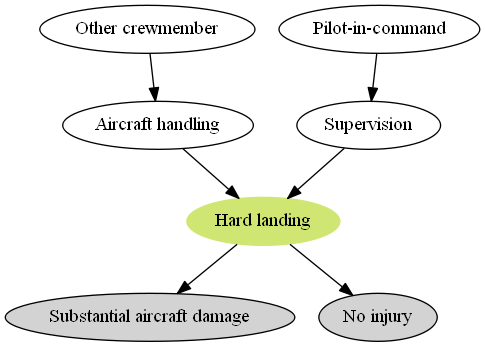

In [61]:
dictAircraftDamage = {'MINR': 'Minor', 'DEST': 'Destroyed', 'NONE': 'None', 'UNK': 'Unknown', 'SUBS': 'Substantial'}
dictEdges = {}
g1 = buildOneGraphRep(sample_ev_ID)
drawImage(g1)
#drawPDF(g1, 'test')

#### Add all the connections for accidents before 2006

In [62]:
df_records.drop(df_records.index, inplace=True)
dictEdges = {}

for sample_ev_ID in ev_ID:
    #print (sample_ev_ID)
    buildOneGraphRep(sample_ev_ID)

In [63]:
setCauses = set(df_records['from'].values)

dictElement = {}

for cause in setCauses:
    outcomes = set(df_records[(df_records['from'] == cause)]['to'].values)
    
    for outcome in outcomes:
        #print ('no causes: ', no_causes)

        key = cause + '->' + outcome

        jointEvents = set(df_records[(df_records['to'] == outcome) & (df_records['from'] == cause)]['eventId'].values)
        denominator = set(df_records[(df_records['from'] == cause) | (df_records['to'] == cause)]['eventId'].values)

        if key not in dictElement.keys():
            dictElement[key] = len(jointEvents)/len(denominator)
            
            if dictElement[key] == 1:
                dictElement[key] = dictElement[key] * 0.95

In [64]:
dictElement

{'Engineassemblyblowerimpellerintegralsupercharger->Lossofenginepowerpartialmechanicalfailuremalfunction': 0.95,
 'Compressorassemblyrotordisc->Lossofenginepowerpartialmechanicalfailuremalfunction': 0.16666666666666666,
 'Compressorassemblyrotordisc->Airframecomponentsystemfailuremalfunction': 0.3333333333333333,
 'Compressorassemblyrotordisc->Lossofenginepowertotalmechanicalfailuremalfunction': 0.5,
 'Fluidwater->Airframecomponentsystemfailuremalfunction': 0.95,
 'Trafficadvisory->Ongroundwatercollisionwithobject': 0.18181818181818182,
 'Trafficadvisory->Miscellaneousother': 0.09090909090909091,
 'Trafficadvisory->Collisionbetweenaircraftotherthanmidair': 0.09090909090909091,
 'Trafficadvisory->Nearcollisionbetweenaircraft': 0.6363636363636364,
 'Miscellaneousengine->Lossofenginepowertotalnonmechanical': 0.5,
 'Miscellaneousengine->Lossofenginepower': 0.5,
 'Altimetersetting->Undershoot': 0.95,
 'Emergencyprocedure->Fireexplosion': 0.058823529411764705,
 'Emergencyprocedure->Fire': 0.

In [65]:
setCauses

{'ATCclearance',
 'ATCpersonnelAirRouteTrafficControlCenterARTCC',
 'ATCpersonnelFlightServiceStationFSS',
 'ATCpersonneldepartureapproach',
 'ATCpersonnellocalgroundclearancedelivery',
 'ATCpersonnelnonFAA',
 'ATCpersonnelsupervisor',
 'Abort',
 'AbortaboveV',
 'Abortedlanding',
 'Abortedtakeoff',
 'Abruptmaneuver',
 'Accessorydriveassembly',
 'Accessorydriveassemblydrivegear',
 'Accessorydriveassemblydriveshaft',
 'Accessorydriveassemblyextensionunit',
 'Accessorydriveassemblyexternalshaftbearing',
 'Ailerontrim',
 'AirRouteTrafficControlCenterARTCCservice',
 'Airconditioningheatingpressurization',
 'Airconditioningheatingpressurizationcabintemperaturecontrol',
 'Airconditioningheatingpressurizationcontrolindicator',
 'Airconditioningheatingpressurizationfreonsystem',
 'Airconditioningheatingpressurizationoutflowvalve',
 'Airconditioningheatingpressurizationpressureregulator',
 'Airconditioningheatingpressurizationsafetyvalve',
 'Aircraftcontrol',
 'Aircraftequipmentinadequate',
 'Ai

In [66]:
dictEdges

{'Firewarningsystempowerplant->Airframecomponentsystemfailuremalfunction': 8,
 'Airframecomponentsystemfailuremalfunction->Noneaircraftdamage': 114,
 'Airframecomponentsystemfailuremalfunction->Noinjury': 231,
 'Flightcrew->Aircraftcontrol': 8,
 'Hydraulicsystem->Airframecomponentsystemfailuremalfunction': 14,
 'Aircraftcontrol->Airframecomponentsystemfailuremalfunction': 1,
 'Airframecomponentsystemfailuremalfunction->Lossofcontrolinflight': 8,
 'Lossofcontrolinflight->Noneaircraftdamage': 12,
 'Lossofcontrolinflight->Noinjury': 12,
 'Passenger->Proceduresdirectives': 6,
 'Manufacturer->MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram': 1,
 'FAAorganization->InadequatesubstantiationprocessInsufficientreview': 1,
 'Miscellaneousequipmentfurnishingslavatories->Fire': 1,
 'Proceduresdirectives->Fire': 2,
 'Firewarningsystemlavatory->Fire': 1,
 'MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram->Fire': 1,
 'InadequatesubstantiationprocessInsuff

In [67]:
len(dictElement)

3158

In [68]:
len(dictEdges)

3158

#### Construct a dataframe to represent all the links in the network

In [69]:
lst = ['name', 'fromID', 'toID', 'count']
df_edges = pd.DataFrame(columns = lst)

for key, value in dictEdges.items():
    name = key
    fromID, toID = str(key).split('->')
    count = dictElement[key]
    
    row = {'name': key, 'fromID': fromID, 'toID': toID, 'count': count}
    df_edges = df_edges.append(row, ignore_index=True)

In [70]:
df_records[df_records['to'] == 'Inflightencounterwithweather']

,eventId,from,to
78,20001213X25233,Weathercondition,Inflightencounterwithweather
79,20001213X25233,Flightintoknownadverseweather,Inflightencounterwithweather
80,20001213X25233,Seatbeltsign,Inflightencounterwithweather
213,20001213X27987,Weathercondition,Inflightencounterwithweather
214,20001213X27987,Antiicedeicesystem,Inflightencounterwithweather
228,20030813X01324,Weathercondition,Inflightencounterwithweather
327,20001213X34081,Inflightplanningdecision,Inflightencounterwithweather
328,20001213X34081,Weathercondition,Inflightencounterwithweather
370,20001212X18718,Weathercondition,Inflightencounterwithweather
371,20001212X18718,Instructionswrittenverbal,Inflightencounterwithweather


In [71]:
parentInfo = df_edges[df_edges['toID'] == 'Inflightencounterwithweather'][['fromID', 'count']].values
sorted(parentInfo, key=lambda x: x[1], reverse = True)

[array(['Preflightbriefingservice', 0.95], dtype=object),
 array(['Inflightweatheradvisories', 0.95], dtype=object),
 array(['Weatherradar', 0.95], dtype=object),
 array(['Weatherforecast', 0.95], dtype=object),
 array(['Meteorologicalservice', 0.95], dtype=object),
 array(['Miscellaneousequipmentfurnishingsfirstaidequipment', 0.95],
       dtype=object),
 array(['Flightcontrolelevatorsurface', 0.95], dtype=object),
 array(['Pressure', 0.95], dtype=object),
 array(['Flightnavigationinstrumentsairspeedindicator', 0.95], dtype=object),
 array(['Flightintoadverseweather', 0.9230769230769231], dtype=object),
 array(['Seatbeltsign', 0.8571428571428571], dtype=object),
 array(['Passengerbriefing', 0.8333333333333334], dtype=object),
 array(['Hazardousweatheradvisory', 0.8333333333333334], dtype=object),
 array(['Seatbelt', 0.8292682926829268], dtype=object),
 array(['Flightintoknownadverseweather', 0.6666666666666666], dtype=object),
 array(['Crewgroupbriefing', 0.625], dtype=object),
 array

### Construct Bayesian network with PySMILE library

#### Construct XDSL file to be fed into PySMILE

In [72]:
import numpy as np
from scipy.optimize import minimize
import scipy.stats

#def CPT_estimation(x, a, b):
#    return (1 + np.exp(a+b))/(1 + np.exp(a/x + b))

def obj(x, normProb, probs):
    diff = (1 + np.exp(x[0]+x[1]))/(1 + np.exp(x[0]/normProb + x[1])) - probs
    return np.sum(diff**2)

def obj_beta(x, normProb, probs):
    pred = []
    for i in normProb:
        beta = scipy.stats.beta.cdf(i, a = x[0], b = x[1])
        #print (beta)
        pred.append(beta)
            
    #print (scipy.stats.beta.cdf(normProb, a = 1, b = 1))
    #diff = scipy.stats.beta.cdf(normProb, a = x[0], b = x[1]) - probs
    diff = pred - probs
    return np.sum(diff**2)

def CPT_estimation(x, a, b):
    return scipy.stats.beta.cdf(x, a = a, b = b)

In [73]:
def binaryConversion(value, n):
    m = eval('"' + "{0:0" + str(n) + "b}" + '"').format(value) ## binary representation
    characters = [int(char) for char in str(m)]
    res = np.array(characters)
    return res

In [74]:
dictParameter = {}

def constructCPT(parentInfo, toID):
    n = parentInfo.shape[0]
    count = parentInfo[:, 1]

    start = 2**n - 1
    
    CPT = []
    lambda_val = sum(count) - 1
    for i in range(start, -1, -1):
        scheme = binaryConversion(i, n)
        
        if sum(scheme) == 1 or sum(scheme) == 0:
            Yes_prob = np.sum(np.multiply(scheme, count))
        else:
            totalContribution = np.sum(count)
            normContribution = count/totalContribution
            
            #normContribution = np.array([min(normContribution), max(normContribution)])
            #probs = np.array([min(count), max(count)])
            
            normContribution = np.array(normContribution)
            probs = np.array(count)
            
            #print (np.isnan(normContribution).any())
            
            if toID not in dictParameter.keys():
                ## calibrate the parameters
                x_0 = [2, 1]
                
                #res = minimize(obj, x_0, args = (normContribution, probs), method='Powell', tol=1e-6)
                res = minimize(obj_beta, x_0, args = (normContribution, probs), method='Nelder-Mead', tol=1e-6)

                a = res.x[0]
                b = res.x[1]
                
                dictParameter[toID] = [a, b]
                
                print ('Obj: ', res.fun, 'a:', a, 'b: ', b)
            else:
                a = dictParameter[toID][0]
                b = dictParameter[toID][1]
            
            CPT_contribution = np.sum(np.multiply(scheme, count))/totalContribution
            Yes_prob = CPT_estimation(CPT_contribution, a, b)
            
            if Yes_prob < max(np.multiply(scheme, count)):
                Yes_prob = max(np.multiply(scheme, count))
                
            #print (Yes_prob, max(np.multiply(scheme, count)))
            
            assert Yes_prob >= max(np.multiply(scheme, count))
            
        No_prob = 1 - Yes_prob
        
        CPT.append(Yes_prob)
        CPT.append(No_prob)
    
    return CPT

def occurrenceTimes(toID):
    toID = set(df_records[df_records['to'] == toID]['eventId'].values)
    fromID = set(df_records[df_records['from'] == toID]['eventId'].values)
    return len(toID.union(fromID))

def occurrenceTimesFromID(fromID):
    return len(set(df_records[df_records['from'] == fromID]['eventId'].values))

In [75]:
#parentInfo = df_edges[df_edges['toID'] == 'Fire'][['fromID', 'count']].values
#constructCPT(parentInfo, 'Fire')

##### Load the license

In [76]:
import pysmile

## load license
pysmile.License((
    b"SMILE LICENSE cd06be93 97a7a599 29f4a47f "
    b"THIS IS AN ACADEMIC LICENSE AND CAN BE USED "
    b"SOLELY FOR ACADEMIC RESEARCH AND TEACHING, "
    b"AS DEFINED IN THE BAYESFUSION ACADEMIC "
    b"SOFTWARE LICENSING AGREEMENT. "
    b"Serial #: ckw9n4254hey3kiszvj6n5k0b "
    b"Issued for: Xiaoge Zhang (zxgcqupt@gmail.com) "
    b"Academic institution: Vanderbilt University "
    b"Valid until: 2020-03-22 "
    b"Issued by BayesFusion activation server"
    ),[
    0xf5,0xdc,0x56,0x91,0x01,0x05,0xdb,0x8d,0xf0,0xbf,0x21,0xe9,0x58,0x09,0x41,0x79,
    0x1f,0xd8,0xd4,0xb3,0x0a,0xaf,0x09,0xad,0xf2,0x41,0x58,0x93,0xc2,0x51,0x28,0xb0,
    0x8d,0xad,0x69,0x38,0x8d,0x82,0x43,0x01,0xca,0xd9,0xd3,0xa2,0x5c,0x98,0xe2,0x9a,
    0x99,0xbf,0xa4,0x17,0x4f,0xbb,0xd6,0x9a,0x72,0xf4,0x23,0xf5,0xed,0x94,0x4b,0x8e])

##### Define the denominator to represent the number of flights from 1982 to 2006

In [77]:
dictEdges

{'Firewarningsystempowerplant->Airframecomponentsystemfailuremalfunction': 8,
 'Airframecomponentsystemfailuremalfunction->Noneaircraftdamage': 114,
 'Airframecomponentsystemfailuremalfunction->Noinjury': 231,
 'Flightcrew->Aircraftcontrol': 8,
 'Hydraulicsystem->Airframecomponentsystemfailuremalfunction': 14,
 'Aircraftcontrol->Airframecomponentsystemfailuremalfunction': 1,
 'Airframecomponentsystemfailuremalfunction->Lossofcontrolinflight': 8,
 'Lossofcontrolinflight->Noneaircraftdamage': 12,
 'Lossofcontrolinflight->Noinjury': 12,
 'Passenger->Proceduresdirectives': 6,
 'Manufacturer->MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram': 1,
 'FAAorganization->InadequatesubstantiationprocessInsufficientreview': 1,
 'Miscellaneousequipmentfurnishingslavatories->Fire': 1,
 'Proceduresdirectives->Fire': 2,
 'Firewarningsystemlavatory->Fire': 1,
 'MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram->Fire': 1,
 'InadequatesubstantiationprocessInsuff

In [78]:
dictEdges.items()

dict_items([('Firewarningsystempowerplant->Airframecomponentsystemfailuremalfunction', 8), ('Airframecomponentsystemfailuremalfunction->Noneaircraftdamage', 114), ('Airframecomponentsystemfailuremalfunction->Noinjury', 231), ('Flightcrew->Aircraftcontrol', 8), ('Hydraulicsystem->Airframecomponentsystemfailuremalfunction', 14), ('Aircraftcontrol->Airframecomponentsystemfailuremalfunction', 1), ('Airframecomponentsystemfailuremalfunction->Lossofcontrolinflight', 8), ('Lossofcontrolinflight->Noneaircraftdamage', 12), ('Lossofcontrolinflight->Noinjury', 12), ('Passenger->Proceduresdirectives', 6), ('Manufacturer->MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram', 1), ('FAAorganization->InadequatesubstantiationprocessInsufficientreview', 1), ('Miscellaneousequipmentfurnishingslavatories->Fire', 1), ('Proceduresdirectives->Fire', 2), ('Firewarningsystemlavatory->Fire', 1), ('MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram->Fire', 1), ('Inadequat

In [79]:
maxElements = 12

def searchThreshold(parentInfo):
    threshold = 0
    
    m = len(np.where(parentInfo[:, 1] > threshold)[0])
    
    while m > maxElements:
        if m < maxElements:
            threshold -= min(parentInfo[:, 1])
        else:
            threshold += min(parentInfo[:, 1])
   
        m = len(np.where(parentInfo[:, 1] > threshold)[0])
    
    if threshold > max(parentInfo[:, 1]):
        threshold = max(parentInfo[:, 1])
    
    return threshold

###### Compute the total number of scheduled flights within USA

In [80]:
departures = pd.read_excel('table_01_37_061019.xlsx')
#departures.drop(departures.columns[0], axis=1, inplace= True)

In [81]:
years = departures.iloc[0].index
flights = departures.iloc[0].values

In [82]:
years = [int(i) for i in years]

Text(0, 0.5, 'Scheduled flights')

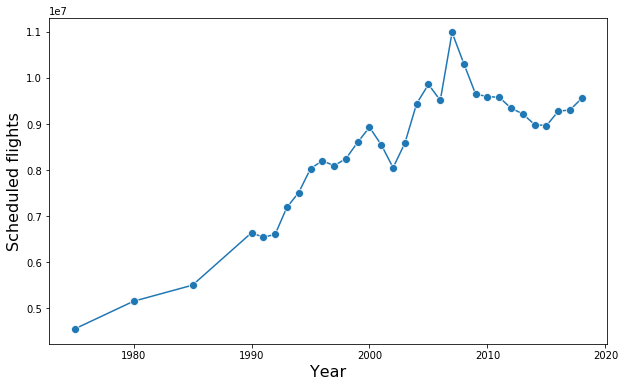

In [83]:
plt.figure(figsize=(10, 6))
sns.lineplot(years, flights, marker = 'o', markersize = 8)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Scheduled flights', fontsize = 16)

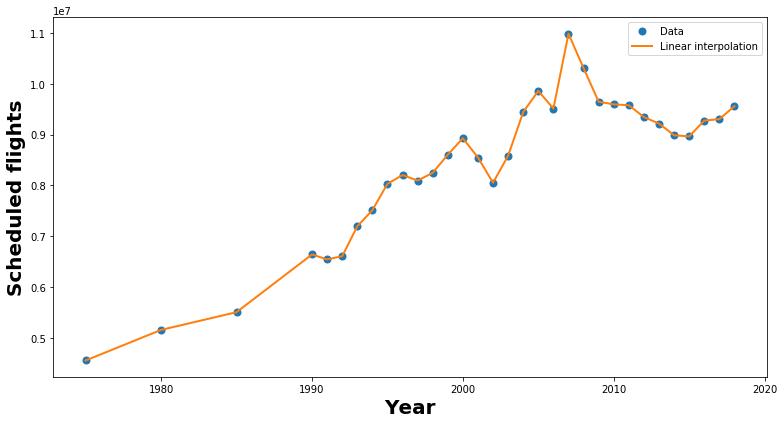

In [84]:
from scipy.interpolate import interp1d

f = interp1d(years, flights)
xnew = np.linspace(1975, 2018, num = 44, endpoint=True)

ax = plt.figure(figsize=(11, 6))
plt.plot(years, flights, 'o', xnew, f(xnew), '-', markersize = 7, linewidth=2)
plt.legend(['Data', 'Linear interpolation'], loc='best')
plt.xlabel('Year', fontsize = 20, fontweight = 'bold')
plt.ylabel('Scheduled flights', fontsize = 20, fontweight = 'bold')
plt.tight_layout()

plt.savefig('departures.pdf')

In [85]:
totalFlights = 0
for i in range(1982, 2007, 1):
    totalFlights += f(i)

In [86]:
totalFlights = round(totalFlights)
print ('The total number of flights from 1982 to 2006 is', totalFlights)

The total number of flights from 1982 to 2006 is 184517128.0


##### Prior probability estimation

In [87]:
set(df_records['to'].values)

{'ATCclearance',
 'Abort',
 'AbortaboveV',
 'Abortedlanding',
 'Abortedtakeoff',
 'Abruptmaneuver',
 'Ailerontrim',
 'AirRouteTrafficControlCenterARTCCservice',
 'Aircraftcontrol',
 'Aircraftequipmentinadequate',
 'Aircraftequipmentinadequateaircraftcomponent',
 'Aircraftequipmentinadequateaircraftmanuals',
 'Aircraftequipmentinadequateairframe',
 'Aircraftequipmentinadequatecompliancedetermination',
 'Aircraftequipmentinadequatecontrolshapesize',
 'Aircraftequipmentinadequatedesign',
 'Aircraftequipmentinadequatehandlingperformancecapabilities',
 'Aircraftequipmentinadequatestandardrequirement',
 'Aircrafthandling',
 'Aircraftpreflight',
 'Aircraftservice',
 'Aircraftweightandbalance',
 'Airframecomponentsystemfailuremalfunction',
 'Airgroundcommunications',
 'Airport',
 'Airportoperations',
 'Airportsnowremoval',
 'Airspeed',
 'AirspeedliftoffspeedVlof',
 'AirspeedminimumcontrolspeedwiththecriticalengineinoperativeVmc',
 'AirspeedreferenceVref',
 'AirspeedrotationspeedVr',
 'Allavail

In [88]:
event = 'Fire'

In [89]:
eventID_list = set(df_records[(df_records['from'] == event) | (df_records['to'] == event)]['eventId'].values)
totalOccurrences = len(eventID_list)
prob_yes = totalOccurrences/totalFlights
prob_no = 1 - prob_yes
print ('Total occurrences of event %s: %d' % (event, totalOccurrences))
print ('Prior probability of fire occurrence is: ', prob_yes)

Total occurrences of event Fire: 102
Prior probability of fire occurrence is:  5.527942099770814e-07


In [90]:
df_records[df_records['eventId'] == '20050209X00169']

,eventId,from,to
6246,20050209X00169,Flightcrew,Visuallookout
6247,20050209X00169,Airportpersonnel,Airport
6248,20050209X00169,FAAotherorganization,Airport
6249,20050209X00169,Visuallookout,Miscellaneousother
6250,20050209X00169,Airport,Miscellaneousother
6251,20050209X00169,Miscellaneousother,Noneaircraftdamage
6252,20050209X00169,Miscellaneousother,Noinjury


##### Conditional probability estimation

In [91]:
causes = set(df_records[df_records['to'] == event]['from'].values)

total = 0
maxOccurrence = -1
prob_set = []
for cause in causes:
    cause_occurrences = len(set(df_records[(df_records['from'] == cause) & (df_records['to'] == event)]['eventId'].values))
    
    #print ('Cause: ', dictNodeLabel[cause], ', Occurrence: ', cause_occurrences, ', Prob: ',
    # cause_occurrences/totalOccurrences)
    
    total += cause_occurrences/totalOccurrences
    prob_set.append(cause_occurrences/totalOccurrences)
    
    
    if cause_occurrences > maxOccurrence:
        maxOccurrence = cause_occurrences
        
print ('The maximum number of occurrence is', maxOccurrence)

The maximum number of occurrence is 32


In [92]:
set(prob_set)

{0.00980392156862745,
 0.0196078431372549,
 0.029411764705882353,
 0.0392156862745098,
 0.049019607843137254,
 0.058823529411764705,
 0.08823529411764706,
 0.3137254901960784}

In [93]:
total

1.7352941176470569

In [94]:
conditional_prob = maxOccurrence/totalOccurrences

In [95]:
totalOccurrences

102

In [96]:
conditional_prob

0.3137254901960784

##### Generate BN

In [97]:
noFlights = totalFlights
random.seed(1)

In [98]:
dictEdges

{'Firewarningsystempowerplant->Airframecomponentsystemfailuremalfunction': 8,
 'Airframecomponentsystemfailuremalfunction->Noneaircraftdamage': 114,
 'Airframecomponentsystemfailuremalfunction->Noinjury': 231,
 'Flightcrew->Aircraftcontrol': 8,
 'Hydraulicsystem->Airframecomponentsystemfailuremalfunction': 14,
 'Aircraftcontrol->Airframecomponentsystemfailuremalfunction': 1,
 'Airframecomponentsystemfailuremalfunction->Lossofcontrolinflight': 8,
 'Lossofcontrolinflight->Noneaircraftdamage': 12,
 'Lossofcontrolinflight->Noinjury': 12,
 'Passenger->Proceduresdirectives': 6,
 'Manufacturer->MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram': 1,
 'FAAorganization->InadequatesubstantiationprocessInsufficientreview': 1,
 'Miscellaneousequipmentfurnishingslavatories->Fire': 1,
 'Proceduresdirectives->Fire': 2,
 'Firewarningsystemlavatory->Fire': 1,
 'MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram->Fire': 1,
 'InadequatesubstantiationprocessInsuff

##### Remove cycles in the Bayesian network

In [99]:
cyclesRows = df_edges[df_edges['fromID'] == df_edges['toID']]

In [100]:
df_edges.drop(cyclesRows.index, inplace = True)

In [101]:
for i in cyclesRows['fromID']:
    dictEdges.pop(str(i) + '->' + str(i))

In [102]:
XDSL = """<?xml version="1.0" encoding="ISO-8859-1"?>
<!-- This network was created in GeNIe Academic, which can be used for educational and research purposes only -->
<smile version="1.0" id="Network1" numsamples="99999999" discsamples="99999999"> """

nodeConstructor = "\n\t<nodes>"
extensions = '\n\t<extensions>'
extensions += """\n\t\t<genie version="1.0" app="GeNIe 2.4.4420.0 ACADEMIC" name="Network1" faultnameformat="nodestate">"""

networkNodes = set([])
allNodeNames = []

## add parent nodes
for key, value in dictEdges.items():
    fromID, toID = key.split('->')
    
    allNodeNames.append(fromID)
    allNodeNames.append(toID)
    
    parentInfo = df_edges[df_edges['toID'] == fromID][['fromID', 'count']].values
        
    if fromID not in networkNodes and len(parentInfo) == 0: ## if the node has no parents, add it first
        #print ('... ', fromID)

        ## compute prior probabilities
        Yes_prob = occurrenceTimesFromID(fromID)/noFlights
        No_prob = 1 - Yes_prob

        ## construct parent nodes
        nodeConstructor += "\n\t\t<cpt id=" + '"' + fromID + '"' + """>"""
        nodeConstructor += """\n\t\t\t<state id="Yes" />\n\t\t\t<state id="No" />"""
        nodeConstructor += "\n\t\t\t<probabilities>" + str(Yes_prob) + " " +  str(No_prob) + "</probabilities>"
        nodeConstructor += '\n\t\t</cpt>'

        ## add extensions for parent nodes
        extensions += "\n\t\t\t<node id=" +  '"' + fromID + '"' + ">"
        extensions += "\n\t\t\t\t<name>" + dictNodeLabel[fromID] + "</name>"
        extensions += """\n\t\t\t\t<interior color="e5f6f7" />"""
        extensions += """\n\t\t\t\t<outline color="000080" />"""
        extensions += """\n\t\t\t\t<font color="000000" name="Arial" size="8" />"""
        extensions += "\n\t\t\t\t<position> 250 160 426 251 </position>"
        extensions += """\n\t\t\t\t<barchart active="true" width="258" height="64" />"""
        extensions += "\n\t\t\t</node>"

        networkNodes.add(fromID)

allNodeNames = set(allNodeNames)

while len(networkNodes) < len(allNodeNames):
    
    ## add child nodes
    for key, value in dictEdges.items():
        fromID, toID = key.split('->')

        parentInfo = df_edges[df_edges['toID'] == toID][['fromID', 'count']].values

        indexMaxValues = np.where(parentInfo[:, 1] == max(parentInfo[:, 1]))[0]
        noMaxValues = len(indexMaxValues)

        if noMaxValues > maxElements:
            ## inject jitter to the maxvalue
            jitter = [random.random() for i in range(noMaxValues)] 
            jitter = np.array(jitter) * min(parentInfo[:, 1])
            parentInfo[indexMaxValues, 1] = parentInfo[indexMaxValues, 1] + jitter

        n = parentInfo.shape[0]

        if n > maxElements:
            delta = searchThreshold(parentInfo)
            parentInfo = parentInfo[np.where(parentInfo[:, 1] >= delta), :][0]

        parentNodeNames = list(parentInfo[:, 0])
        
        
        if toID not in networkNodes and set(parentNodeNames).issubset(set(networkNodes)):
            
            print ('yes----->')

            ## build conditional probability table
            CPT = constructCPT(parentInfo, toID)

            CPT_str = list(map(str, CPT))

            childDesp = "\n\t\t<cpt id=" + '"' + str(toID) + '"' + """>"""
            childDesp += """\n\t\t\t<state id="Yes" />\n\t\t\t<state id="No" />"""
            childDesp += "\n\t\t\t<parents>" + ' '.join(parentNodeNames) + "</parents>"
            childDesp += "\n\t\t\t<probabilities>"+ ' '.join(CPT_str)+"</probabilities>"
            childDesp += "\n\t\t</cpt>"

            nodeConstructor += childDesp
            networkNodes.add(toID)
            
            print (len(networkNodes))

            ## add child node
            extensions += "\n\t\t\t<node id=" +  '"' + toID + '"' + ">"
            extensions += "\n\t\t\t\t<name>" + dictNodeLabel[toID] + "</name>"
            extensions += """\n\t\t\t\t<interior color="e5f6f7" />"""
            extensions += """\n\t\t\t\t<outline color="000080" />"""
            extensions += """\n\t\t\t\t<font color="000000" name="Arial" size="8" />"""
            extensions += "\n\t\t\t\t<position> 250 160 426 251 </position>"
            extensions += """\n\t\t\t\t<barchart active="true" width="258" height="64" />"""
            extensions += "\n\t\t\t</node>"
            
nodeConstructor += "\n\t</nodes>"
extensions += '\n\t\t</genie>'
extensions += '\n\t</extensions>'

yes----->
378
yes----->
Obj:  1.6916004130038914e-06 a: 0.8636326380092758 b:  0.09702098608363842
379
yes----->
Obj:  6.561375959381164e-06 a: 1.0645399145135133 b:  1.9920285676217588
380
yes----->
Obj:  4.051799149800336e-05 a: 0.8783442042532543 b:  0.5986555643939647
381
yes----->
Obj:  5.29422439031497e-07 a: 0.8292505265573702 b:  0.03988946025323383
382
yes----->
383
yes----->
384
yes----->
Obj:  5.696268661764859e-07 a: 1.0149629797304986 b:  1.1843073394237391
385
yes----->
Obj:  5.1753318231966015e-18 a: 0.6526261512320577 b:  0.01248468895350638
386
yes----->
Obj:  7.623795313706039e-07 a: 1.0164372813021851 b:  1.243327256299627
387
yes----->
Obj:  3.7423731306308896e-05 a: 0.8843410398469748 b:  0.3143758911505576
388
yes----->
Obj:  1.0468825308442677e-08 a: 0.7593220195495763 b:  0.017803335581508498
389
yes----->
Obj:  1.6700695104762977e-06 a: 0.8548819960131793 b:  0.06131720264895979
390
yes----->
391
yes----->
Obj:  1.9236274666943434e-18 a: 0.6544774148034997 b:  

Obj:  9.911079712573538e-09 a: 0.7678347389771871 b:  0.01864731466815388
487
yes----->
Obj:  6.435391386539174e-11 a: 0.8626177296256216 b:  0.035737691801493235
488
yes----->
Obj:  5.004968301435965e-18 a: 0.6662260117087858 b:  0.0058944193799818426
489
yes----->
Obj:  2.722179166749833e-18 a: 0.6506115348975149 b:  0.005100649385934087
490
yes----->
Obj:  2.863300597722411e-18 a: 0.6518424210863696 b:  0.005598747184140905
491
yes----->
Obj:  1.0258353553207468e-06 a: 0.8370224513102814 b:  0.054694318809094665
492
yes----->
Obj:  5.226221306434622e-08 a: 0.758971253329119 b:  0.02624068413142366
493
yes----->
Obj:  1.3175682411587941e-17 a: 0.6566662428643234 b:  0.02717291768040765
494
yes----->
Obj:  2.1132421130437922e-05 a: 0.7817635189378401 b:  0.1584401611250425
495
yes----->
Obj:  3.3686219316486547e-06 a: 0.9023434235205982 b:  0.26329818957348805
496
yes----->
Obj:  2.334139571378235e-06 a: 0.9047386514845466 b:  0.26500028123850006
497
yes----->
Obj:  3.3028634047686362

Obj:  5.58989469832127e-08 a: 0.8040289412817868 b:  0.01849100309863911
601
yes----->
602
yes----->
603
yes----->
604
yes----->
Obj:  2.722179166749833e-18 a: 0.6506115348975149 b:  0.005100649385934087
605
yes----->
Obj:  0.01382556973423674 a: 3.171571430901206 b:  51.42539202975658
606
yes----->
607
yes----->
Obj:  1.1137165350402105e-18 a: 0.651400090558334 b:  0.007649584602701121
608
yes----->
Obj:  1.6781661965810837e-17 a: 0.6586460514827973 b:  0.004265857656265523
609
yes----->
610
yes----->
Obj:  6.436711952366391e-08 a: 0.7842075798610513 b:  0.034366185119959494
611
yes----->
Obj:  3.524360477403681e-20 a: 0.6498236111230302 b:  0.007595056765677835
612
yes----->
Obj:  3.699334292492985e-18 a: 0.6530879506468314 b:  0.0032044826237602473
613
yes----->
Obj:  2.6231791712762833e-05 a: 1.1269000442961246 b:  2.4653623308740804
614
yes----->
Obj:  4.358033421047933e-06 a: 0.7563213814124231 b:  0.0535476386427648
615
yes----->
616
yes----->
Obj:  7.721848542054898e-08 a: 0.79

In [106]:
set(allNodeNames) - set(networkNodes)

set()

In [107]:
df_edges[df_edges['toID'] == 'Propellerblastorjetexhaustsuction']['fromID'].values

array(['Visuallookout', 'Proceduresdirectives',
       'Unsafehazardouscondition', 'Planningdecision',
       'Lackoftotalexperienceintypeoperation', 'Object',
       'Airportfacilitiestaxiwaycondition', 'Aircrafthandling',
       'Clearance', 'Inadequatetraining', 'Procedureinadequate',
       'Miscellaneousequipmentfurnishingswheelchocks',
       'Identificationofaircraftvisually'], dtype=object)

In [108]:
set(df_edges[df_edges['toID'] == 'Noneaircraftdamage']['fromID'].values) - set(networkNodes)

set()

In [109]:
df_edges[df_edges['toID'] == 'Propellerblastorjetexhaustsuction']

,name,fromID,toID,count
30,Visuallookout->Propellerblastorjetexhaustsuction,Visuallookout,Propellerblastorjetexhaustsuction,0.014706
31,Proceduresdirectives->Propellerblastorjetexhau...,Proceduresdirectives,Propellerblastorjetexhaustsuction,0.027586
305,Unsafehazardouscondition->Propellerblastorjete...,Unsafehazardouscondition,Propellerblastorjetexhaustsuction,0.052632
306,Planningdecision->Propellerblastorjetexhaustsu...,Planningdecision,Propellerblastorjetexhaustsuction,0.153846
698,Lackoftotalexperienceintypeoperation->Propelle...,Lackoftotalexperienceintypeoperation,Propellerblastorjetexhaustsuction,0.333333
1369,Object->Propellerblastorjetexhaustsuction,Object,Propellerblastorjetexhaustsuction,0.021277
1370,Airportfacilitiestaxiwaycondition->Propellerbl...,Airportfacilitiestaxiwaycondition,Propellerblastorjetexhaustsuction,0.111111
1371,Aircrafthandling->Propellerblastorjetexhaustsu...,Aircrafthandling,Propellerblastorjetexhaustsuction,0.038462
2648,Clearance->Propellerblastorjetexhaustsuction,Clearance,Propellerblastorjetexhaustsuction,0.022727
2649,Inadequatetraining->Propellerblastorjetexhaust...,Inadequatetraining,Propellerblastorjetexhaustsuction,0.090909


In [110]:
dictNodeLabel

{'Fatalinjury': 'Fatal injury',
 'Seriousinjury': 'Serious injury',
 'Minorinjury': 'Minor injury',
 'Noinjury': 'No injury',
 'Unknownreason': 'Unknown reason',
 'Supervision': 'Supervision',
 'Pilotincommand': 'Pilot-in-command',
 'Aircrafthandling': 'Aircraft handling',
 'Othercrewmember': 'Other crewmember',
 'Hardlanding': 'Hard landing',
 'Landing': 'Landing',
 'Substantialaircraftdamage': 'Substantial aircraft damage',
 'Firewarningsystempowerplant': 'Fire warning system, powerplant',
 'Airframecomponentsystemfailuremalfunction': 'Airframe/component/system failure/malfunction',
 'Cruisenormal': 'Cruise - normal',
 'Noneaircraftdamage': 'None aircraft damage',
 'Hydraulicsystem': 'Hydraulic system',
 'Aircraftcontrol': 'Aircraft control',
 'Flightcrew': 'Flight crew',
 'Approach': 'Approach',
 'Lossofcontrolinflight': 'Loss of control - in flight',
 'Miscellaneousequipmentfurnishingslavatories': 'Miscellaneous equipment/furnishings, lavatories',
 'Proceduresdirectives': 'Procedur

In [111]:
len(dictEdges)

3146

In [112]:
dictEdges

{'Firewarningsystempowerplant->Airframecomponentsystemfailuremalfunction': 8,
 'Airframecomponentsystemfailuremalfunction->Noneaircraftdamage': 114,
 'Airframecomponentsystemfailuremalfunction->Noinjury': 231,
 'Flightcrew->Aircraftcontrol': 8,
 'Hydraulicsystem->Airframecomponentsystemfailuremalfunction': 14,
 'Aircraftcontrol->Airframecomponentsystemfailuremalfunction': 1,
 'Airframecomponentsystemfailuremalfunction->Lossofcontrolinflight': 8,
 'Lossofcontrolinflight->Noneaircraftdamage': 12,
 'Lossofcontrolinflight->Noinjury': 12,
 'Passenger->Proceduresdirectives': 6,
 'Manufacturer->MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram': 1,
 'FAAorganization->InadequatesubstantiationprocessInsufficientreview': 1,
 'Miscellaneousequipmentfurnishingslavatories->Fire': 1,
 'Proceduresdirectives->Fire': 2,
 'Firewarningsystemlavatory->Fire': 1,
 'MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram->Fire': 1,
 'InadequatesubstantiationprocessInsuff

In [113]:
len(networkNodes)

740

In [114]:
XDSL += nodeConstructor
XDSL += extensions
XDSL += '\n</smile>'

In [115]:
### Write XDSL to file
file = open("NTSB.xdsl","w")
file.write(XDSL)

#print (XDSL)

5695834

### Perform Bayesian Inference

In [116]:
import pysmile

## load license
# pysmile.License((
#     b"SMILE LICENSE cd06be93 97a7a599 29f4a47f "
#     b"THIS IS AN ACADEMIC LICENSE AND CAN BE USED "
#     b"SOLELY FOR ACADEMIC RESEARCH AND TEACHING, "
#     b"AS DEFINED IN THE BAYESFUSION ACADEMIC "
#     b"SOFTWARE LICENSING AGREEMENT. "
#     b"Serial #: ckw9n4254hey3kiszvj6n5k0b "
#     b"Issued for: Xiaoge Zhang (zxgcqupt@gmail.com) "
#     b"Academic institution: Vanderbilt University "
#     b"Valid until: 2020-03-22 "
#     b"Issued by BayesFusion activation server"),
#     [0xf5,0xdc,0x56,0x91,0x01,0x05,0xdb,0x8d,0xf0,0xbf,0x21,0xe9,0x58,0x09,0x41,0x79,
#     0x1f,0xd8,0xd4,0xb3,0x0a,0xaf,0x09,0xad,0xf2,0x41,0x58,0x93,0xc2,0x51,0x28,0xb0,
#     0x8d,0xad,0x69,0x38,0x8d,0x82,0x43,0x01,0xca,0xd9,0xd3,0xa2,0x5c,0x98,0xe2,0x9a,
#     0x99,0xbf,0xa4,0x17,0x4f,0xbb,0xd6,0x9a,0x72,0xf4,0x23,0xf5,0xed,0x94,0x4b,0x8e])

In [117]:
class BN:
    def __init__(self):
        print ('Loading the generated Bayesian network')

    def get_node_id_by_name(self, name):
        for handle in net.get_all_nodes():
            if net.get_node_id(handle) == name:
                return handle
    
    def print_posterior_probs(self, node_id):
        posteriors = net.get_node_value(node_id) ## marginal distribution
        nodeName= net.get_node_name(node_id)

        for i in range(0, len(posteriors)):
            print("P(" + nodeName + "=" + net.get_outcome_id(node_id, i) + ")=" + str(posteriors[i]))
            
    def print_consequence_prob(self, node_id):
        childNodes = net.get_children(node_id)
        for child in childNodes:
            posteriors = net.get_node_value(child)
            node_id = net.get_node_id(child)
            
            for i in range(0, len(posteriors)):
                if net.get_outcome_id(node_id, i) == 'Yes':
                    print("P(" + node_id + "=" + net.get_outcome_id(node_id, i) + ")=" + str(posteriors[i]))
     
    def get_node_definition(self, node_id):
        return net.get_node_definition(node_id)
        
    def change_evidence_and_update(self, node_id):
        print ("Before observing " + str(net.get_node_name(node_id)) + "----------->")
        self.print_posterior_probs(node_id)
        
        print ("\n")
        print ("----- Consequence")
        self.print_consequence_prob(node_id)
        net.set_evidence(node_id, 0)
        net.update_beliefs()
        
        print ('\n')
        print ("After observing " + str(net.get_node_name(node_id)) + "----------->")
        self.print_posterior_probs(node_id)
        
        print ("\n")
        print ("----- Consequence")
        self.print_consequence_prob(node_id)

In [118]:
net = pysmile.Network()

net.read_file("NTSB.xdsl")
net.update_beliefs()

network = BN()

SMILEException: pysmile.Network.update_beliefs() raised exception!
errno = -42

### Model validation -- Part I

##### Change prior probabilites

In [ ]:
def get_outcome(nodeID):
    childNodes = net.get_children(nodeID)

    for child in childNodes:
        posteriors = net.get_node_value(child)
        node_id = net.get_node_id(child)

        for i in range(0, len(posteriors)):
            if net.get_outcome_id(node_id, i) == 'Yes':
                print("P(" + node_id + "=" + net.get_outcome_id(nodeID, i) + ")=" + str(posteriors[i]))

In [ ]:
landinggearNodeID = network.get_node_id_by_name("Landinggearmaingearstrut")

Yes = net.get_node_definition(landinggearNodeID)[0]
originalProb = Yes

In [ ]:
listProb = [Yes, 10*Yes, 100*Yes, 10000*Yes, 1000000*Yes, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1]

for p in listProb:
    print ("The occurrence probability of landing gear main gear strut is ", p)
    
    nodeDef = [p,  1-p]
    
    net.set_node_definition(landinggearNodeID, nodeDef)
    net.update_beliefs()
    
    get_outcome(landinggearNodeID)
    
    print ("\n")
    

nodeDef = [originalProb, 1 - originalProb]
net.set_node_definition(landinggearNodeID, nodeDef)
net.update_beliefs()

### Model validation -- Part II

#### Observe more and more evidences

###### Observe landing gear main gear strut

In [ ]:
nodeName = "Landinggearmaingearstrut"
nodeID = network.get_node_id_by_name(nodeName)

network.change_evidence_and_update(nodeID)

consequenceList = ["Destroyedaircraftdamage", "Minoraircraftdamage", "Minorinjury"]
consequence = []

print ("\n")
for item in consequenceList:
    NodeID = network.get_node_id_by_name(item)
    res = net.get_node_value(NodeID)
    print ("Yes and No probs of " + item + " " + str(res))
    
    consequence.append(res)

###### Observe landing gear emergency extension assembly

In [ ]:
nodeName = "Landinggearemergencyextensionassembly"
nodeID = network.get_node_id_by_name(nodeName)
network.change_evidence_and_update(nodeID)

print ("\n")
for item in consequenceList:
    NodeID = network.get_node_id_by_name(item)
    
    res = net.get_node_value(NodeID)
    print ("Yes and No probs of " + item + " " + str(res))
    
    consequence.append(res)

###### Observe landing gear  locking mechanism

In [ ]:
nodeName = "Landinggeargearlockingmechanism"
nodeID = network.get_node_id_by_name(nodeName)
network.change_evidence_and_update(nodeID)

print ("\n")
for item in consequenceList:
    NodeID = network.get_node_id_by_name(item)
    
    res = net.get_node_value(NodeID)
    print ("Yes and No probs of " + item + " " + str(res))
    
    consequence.append(res)

###### Observe landing gear main gear attachment

In [ ]:
nodeName = "Landinggearmaingearattachment"
nodeID = network.get_node_id_by_name(nodeName)
network.change_evidence_and_update(nodeID)

print ("\n")
for item in consequenceList:
    NodeID = network.get_node_id_by_name(item)
        
    res = net.get_node_value(NodeID)
    print ("Yes and No probs of " + item + " " + str(res))
    
    consequence.append(res)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

consequence = np.array(consequence)

df = pd.DataFrame([['Landing gear \n main gear strut', 'Destroyed aircraft damage', consequence[0, 0]],
                   ['Landing gear \n emergency extension assembly', 'Destroyed aircraft damage', consequence[3, 0]],
                   ['Landing gear \n locking mechanism', 'Destroyed aircraft damage', consequence[6, 0]],
                   ['Landing gear \n main gear attachment', 'Destroyed aircraft damage', consequence[9, 0]],
                   ['Landing gear \n main gear strut', 'Minor aircraft damage', consequence[1, 0]],
                   ['Landing gear \n emergency extension assembly', 'Minor aircraft damage', consequence[4, 0]],
                   ['Landing gear \n locking mechanism', 'Minor aircraft damage', consequence[7, 0]],
                   ['Landing gear \n main gear attachment', 'Minor aircraft damage', consequence[10, 0]],
                   ['Landing gear \n main gear strut', 'Minor personnel injury', consequence[2, 0]],
                   ['Landing gear \n emergency extension assembly', 'Minor personnel injury', consequence[5, 0]],
                   ['Landing gear \n locking mechanism', 'Minor personnel injury', consequence[8, 0]],
                   ['Landing gear \n main gear attachment', 'Minor personnel injury', consequence[11, 0]]], 
                  columns=['stage','Outcome','val'])

df_pivot = df.pivot("stage", "Outcome", "val").reset_index()

order = ['Landing gear \n main gear strut', 'Landing gear \n emergency extension assembly', 
         'Landing gear \n locking mechanism', 'Landing gear \n main gear attachment']

mapping = {day: i for i, day in enumerate(order)}
key = df_pivot['stage'].map(mapping)    
df_pivot = df_pivot.iloc[key.argsort()]

params = {'legend.fontsize': 20, 'legend.handlelength': 2}
plt.rcParams.update(params)

# Draw the bar chart
ax = df_pivot.plot(kind='bar', x='stage', figsize=(18, 11))
ax.set_xlabel("Observed evidence", fontsize = 24, fontweight = 'bold')
ax.set_ylabel("Probability", fontsize = 24, fontweight = 'bold')
plt.xticks(rotation=0)
plt.tick_params(axis='x', labelsize=17)
plt.tick_params(axis='y', labelsize=17)

plt.savefig('evidence.pdf')

In [ ]:
for i in net.get_all_nodes():
    parent_ids = net.get_parent_ids(i)
    
    child_ids = net.get_child_ids(i)
    #print (parent_ids)
    if len(parent_ids) == 0 and len(child_ids) >= 2:
        print (net.get_node_name(i))

### 1. Scenario analysis

In [ ]:
net = pysmile.Network()

net.read_file("NTSB.xdsl")
net.update_beliefs()

network = BN()

In [ ]:
seq_of_events[seq_of_events['Subj_Code'] == 23110]